## Insurance Cost Prediction

Bu veri seti, kişinin yaşı, cinsiyeti, cinsiyeti, bmi, bölge, sigara kullanıp kullanmama gibi bilgilerini içeriyor. Sağlık sigortası maliyetlerini arttıran değişkenleri analiz edeceğiz. Bu projede, tıbbi sigorta maliyetlerini tahmin etmek için denetimli(supervised) öğrenmenin regresyon tekniklerini uygulayacağım.


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


In [4]:
#import data
data = pd.read_csv("insurance.csv")

In [5]:
print(data.head(15))

    age     sex     bmi  children smoker     region      charges
0    19  female  27.900         0    yes  southwest  16884.92400
1    18    male  33.770         1     no  southeast   1725.55230
2    28    male  33.000         3     no  southeast   4449.46200
3    33    male  22.705         0     no  northwest  21984.47061
4    32    male  28.880         0     no  northwest   3866.85520
5    31  female  25.740         0     no  southeast   3756.62160
6    46  female  33.440         1     no  southeast   8240.58960
7    37  female  27.740         3     no  northwest   7281.50560
8    37    male  29.830         2     no  northeast   6406.41070
9    60  female  25.840         0     no  northwest  28923.13692
10   25    male  26.220         0     no  northeast   2721.32080
11   62  female  26.290         0    yes  southeast  27808.72510
12   23    male  34.400         0     no  southwest   1826.84300
13   56  female  39.820         0     no  southeast  11090.71780
14   27    male     NaN  

### Data Preparation 


In [6]:
#Handle Missing Value
#In python world missing value represent  as NaN(=missing) values
#NaN= Not a Number
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1333 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- Üç tane kolonumuz kategorik değişken bunlar; sex, smoker ve region. Bu değişkenlerimizi numerik değişkene çevireceğiz.

In [7]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1333.000000,1338.000000,1338.000000
mean,39.207025,30.658545,1.094918,13270.422265
std,14.049960,6.092785,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.315000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.675000,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
#Check how many values are missing(NaN) for each column
count_nan = data.isnull().sum()
print(count_nan[count_nan>0])

bmi    5
dtype: int64


- Eksik verilerimizi tespit ettik. "bmi" kolonunda 5 veri eksik, bunları eksik veri çözümlerinden bir tanesi olan kolonun ortalama değeri ile dolduralım.

In [9]:
#fill in the missing values 
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

In [10]:
#cheking how many values are missing after filling
count_nan = data.isnull().sum()
print(count_nan[count_nan>0])

Series([], dtype: int64)


- Eksik veri kontrolünü yine yaptık ve eksik verimiz kalmadı. 

### Exploratory Data Analysis

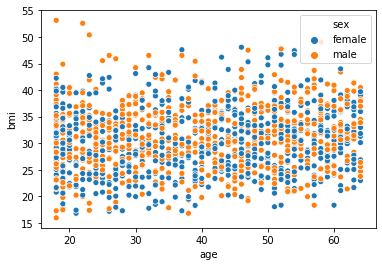

In [11]:
sns.scatterplot(x="age", y="bmi", hue='sex',data=data,color='red')

- Bmi(boy kilo indeksi) ile age(yaş) arasında bir ilişki görülmedi.

Text(0.5, 1.0, 'Distribution of ages of female')

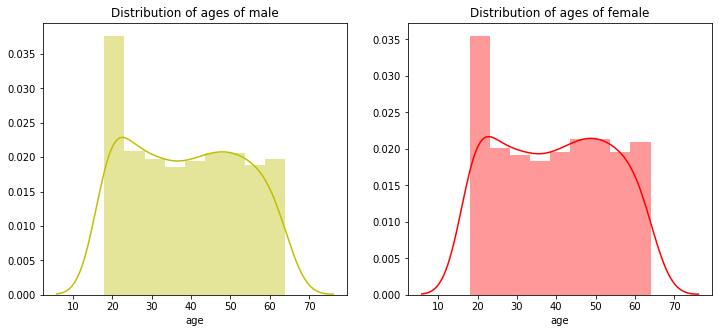

In [12]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.sex == 'male')]["age"],color='y',ax=ax)
ax.set_title('Distribution of ages of male')

ax=f.add_subplot(122)
sns.distplot(data[(data.sex == 'female')]['age'],color='r',ax=ax)
ax.set_title('Distribution of ages of female')

- Gördüğünüz gibi kadın ve erkeklerin yaş dağılımı hemen hemen aynı.

Text(0.5, 1.0, 'Distribution of ages of non smoker')

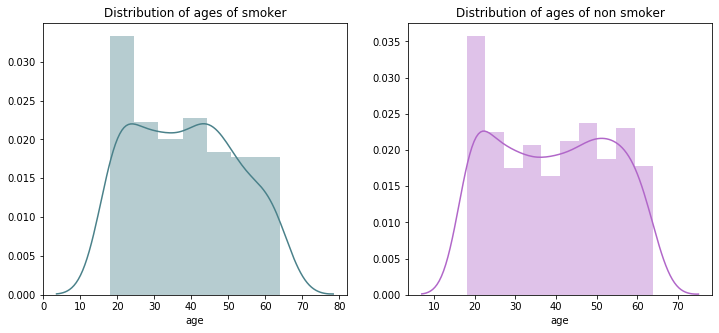

In [13]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 'yes')]["age"],color='#4a818a',ax=ax)
ax.set_title('Distribution of ages of smoker')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 'no')]['age'],color='#b167c9',ax=ax)
ax.set_title('Distribution of ages of non smoker')

- Gördüğünüz gibi sigara içen ve içmeyenlerin dağılımında küçük bir fark var ve ayrıca 18-22 yaş grubu yüzdesinde ilginç bir artış olduğunu görebiliyoruz.


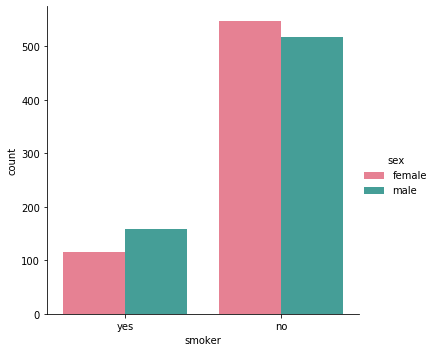

In [14]:
sns.catplot(x="smoker", kind="count",hue = 'sex',palette='husl',data=data)

- Sigara içen erkek sayısı sigara içen kadınlardan daha fazla ve sigara içmeyen kadın sayısı da sigara içmeyen erkek sayısından fazla olduğu görülüyor.

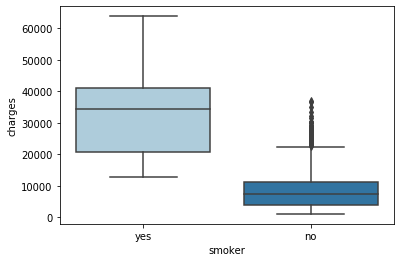

In [15]:
sns.boxplot(x='smoker',y='charges',palette='Paired',data=data)

- Sigara içenlerin sigorta masrafları sigara içmeyenlerden çok daha fazla olduğu görülüyor.

Text(0.5, 1.0, 'Distribution of charges of non smoker')

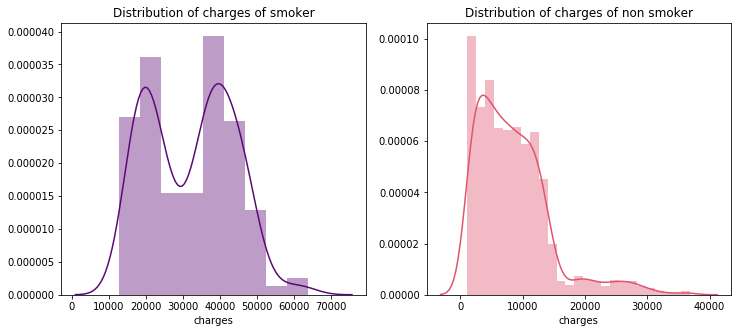

In [16]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 'yes')]["charges"],color='#5b0875',ax=ax)
ax.set_title('Distribution of charges of smoker')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 'no')]['charges'],color='#e0536d',ax=ax)
ax.set_title('Distribution of charges of non smoker')

- İlk grafikte sigara içenlerin sigorta masrafları 60000'i geçerken, ikinci grafikte sigara içmeyenlerin sigorta masrafı maksimum 40000 civarında oluyor. Burda sigara içmenin sigorta masrafını arttırdığını söyleyebiliriz.

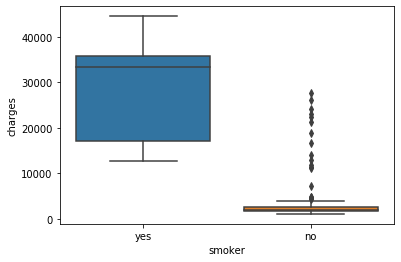

In [17]:
sns.boxplot(x='smoker',y='charges',data=data[(data.age>=18)&(data.age<=22)])

- Gördüğümüz gibi, sigara içmeyen 18-22 yaş arası hastalar, sigara içmeyenlere göre tedaviye çok daha fazla para harcıyor. Sigara içmeyenlerde bazı aykırı değerler görmemize rağmen, bunun nedeni bazı ciddi hastalıklar olabilir.

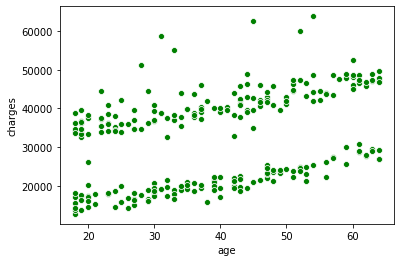

In [18]:
sns.scatterplot(x="age", y="charges", data=data[data.smoker=='yes'],color='green')

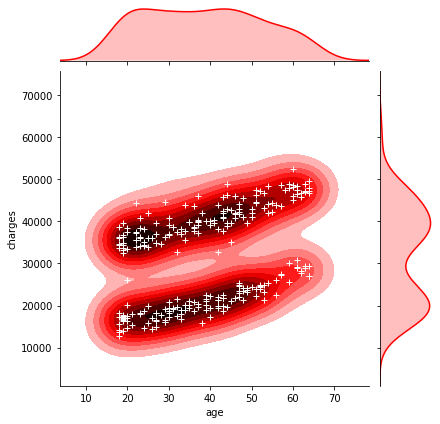

In [19]:
g = sns.jointplot(x="age", y="charges", data=data[data.smoker=='yes'], kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("age", "charges");

- Sigara içenlerin age(yaş) ve charges(sigorta masrafı) dağılımları

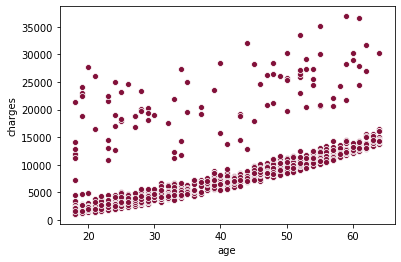

In [20]:
sns.scatterplot(x="age", y="charges", data=data[data.smoker=='no'],color='#82113a')

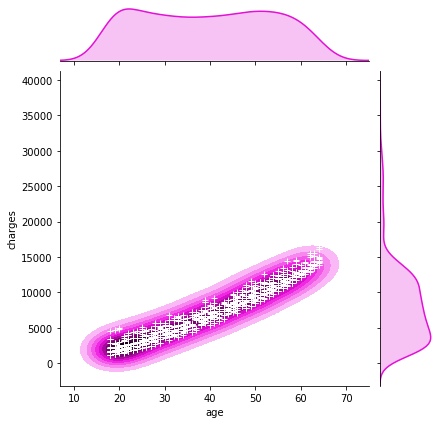

In [21]:
g = sns.jointplot(x="age", y="charges", data=data[data.smoker=='no'], kind="kde", color="#e310d5")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("age", "charges");

- Sigara içmeyenlerin age ve charge dağılımları

Text(0.5, 1.0, 'Distribution of bmi of female')

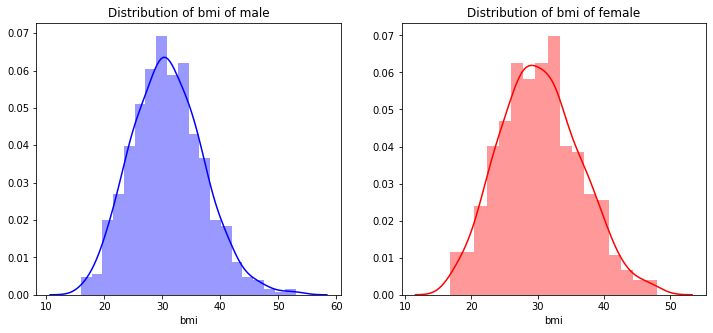

In [22]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.sex == 'male')]["bmi"],color='b',ax=ax)
ax.set_title('Distribution of bmi of male')

ax=f.add_subplot(122)
sns.distplot(data[(data.sex == 'female')]['bmi'],color='r',ax=ax)
ax.set_title('Distribution of bmi of female')

- Erkek ve kadın bmi dağılımı normal dağılım gösteriyor.

Text(0.5, 1.0, 'Distribution of bmi of non smoker')

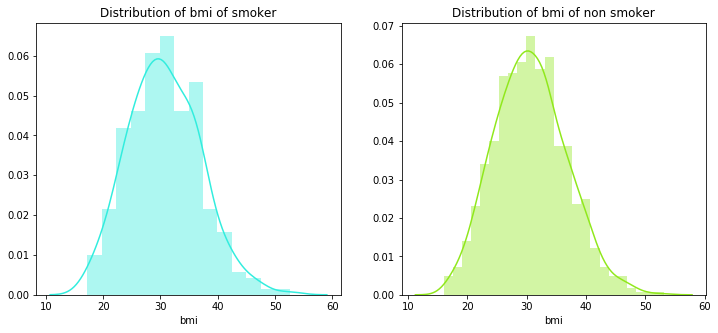

In [23]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 'yes')]["bmi"],color='#32edde',ax=ax)
ax.set_title('Distribution of bmi of smoker')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 'no')]['bmi'],color='#90e81c',ax=ax)
ax.set_title('Distribution of bmi of non smoker')

- Sigara içenlerin ve içmeyenlerin bmi(boy kilo indeksi) normal dağılım gösteriyor.

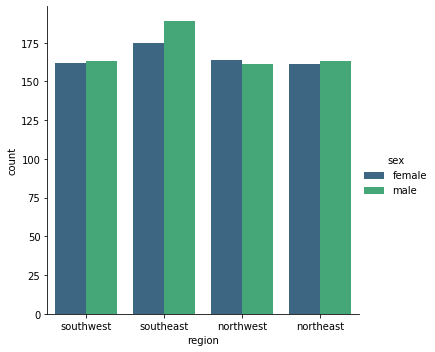

In [24]:
sns.catplot(x="region", kind="count",hue = 'sex',palette='viridis',data=data)

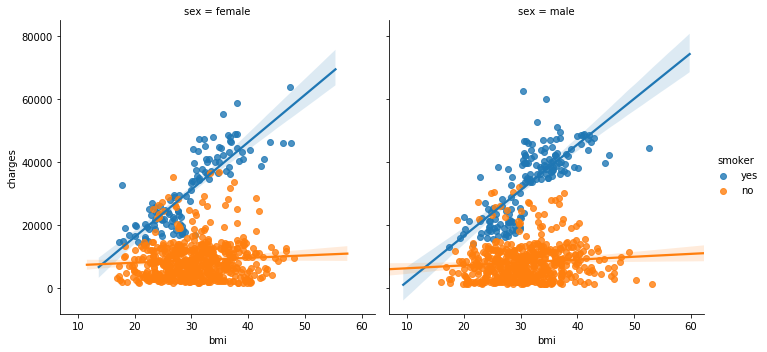

In [25]:
sns.lmplot(x="bmi", y="charges", hue="smoker", col="sex", data=data);

#### Correlation matrix

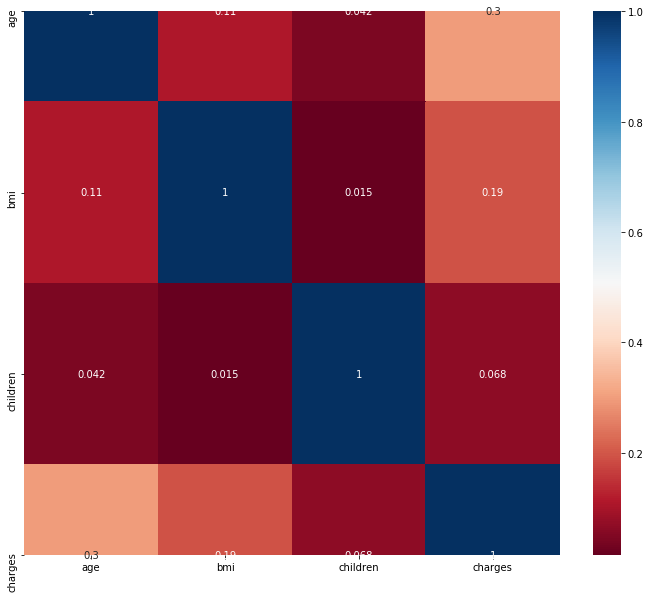

In [26]:
# Let's check the correlation coefficients to see which variables are highly correlated. 

plt.figure(figsize = (12,10))
sns.heatmap(data.corr(), annot = True, cmap="RdBu")
plt.show()

- Isı haritası, hangi değişkenin doğası gereği çok doğrusal olduğunu ve hangi değişkenin hedef değişkenle yüksek doğrusallığa sahip olduğunu açıkça gösterir. 

Şimdi kategorik değişkenlerimizi numerik değişkenlere çevirelim. Buna işleme **Label Encoding** denir. Aşağıdaki görselimizde olduğu gibi Smoker kolonu kategorik bir değişken ve bilgisayarımızın anlayacağı dile çevirmemiz gerekir yani **nümerik** değişken yapmalıyız. Bu örneğimizde "yes" = "1", "no" = "0" olacak şekilde Label Encoding yapacağız.

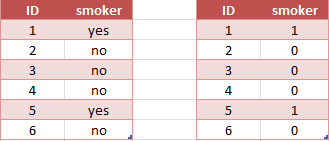

In [27]:
#sklearn Label Encoding
#create ndarray for label encoding(sklearn)
sex = data.iloc[:,1:2].values


#Label Encoder = le
## le for sex
le = LabelEncoder()
sex[:,0] = le.fit_transform(sex[:,0])
sex = pd.DataFrame(sex)
sex.column =['sex']
le_sex_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Sklearn label encoder result for sex:")
print(le_sex_mapping)
print(sex[:10])


Sklearn label encoder result for sex:
{'female': 0, 'male': 1}
   0
0  0
1  1
2  1
3  1
4  1
5  0
6  0
7  0
8  1
9  0


C:\Users\kader\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()


In [28]:
## le for smoker
smoker = data.iloc[:,4:5].values
le = LabelEncoder()
smoker[:,0] = le.fit_transform(smoker[:,0])
smoker = pd.DataFrame(smoker)
smoker.column =['smoker']
le_smoker_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Sklearn label encoder results for smoker:")
print(le_smoker_mapping)
print(smoker[:10])

Sklearn label encoder results for smoker:
{'no': 0, 'yes': 1}
   0
0  1
1  0
2  0
3  0
4  0
5  0
6  0
7  0
8  0
9  0


C:\Users\kader\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


Diyelim ki ikiden fazla renklerin olduğu kategorik değişkenlerimizi nasıl numerik değişkenlere çevireceğiz. Malesef burda Label Encoding yapamıyoruz. Çünkü 0,1,2 diye değiştirirsek sayılar arasında büyüklük küçüklük oranı nedeniyle uygun sonuç alamayacağız. Buna çözüm olarak **"One Hot Encoding"** diye adlandırılan yöntemi kullanacağız. Bu yöntemde seçtiğimiz değişkene "1" diğerlerine "0" vereceğiz böylelikle istenilen değişken Red[0110] gibi bir vektör olarak karşımıza çıkacaktır.
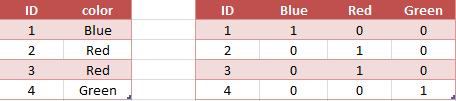

In [29]:
#sklearn one hot encoding :maps each category to 
region = data.iloc[:,5:6].values
#one hot encoder =ohe
ohe = OneHotEncoder()
#create ndarray for one hot encoding(sklearn)
region = ohe.fit_transform(region).toarray()

region = pd.DataFrame(region)

region.columns = ['northeast','northwest','southeast','southwest']
print("Sklearn one hot encoder results for region")
print(region[:10])
type(region)

Sklearn one hot encoder results for region
   northeast  northwest  southeast  southwest
0        0.0        0.0        0.0        1.0
1        0.0        0.0        1.0        0.0
2        0.0        0.0        1.0        0.0
3        0.0        1.0        0.0        0.0
4        0.0        1.0        0.0        0.0
5        0.0        0.0        1.0        0.0
6        0.0        0.0        1.0        0.0
7        0.0        1.0        0.0        0.0
8        1.0        0.0        0.0        0.0
9        0.0        1.0        0.0        0.0


pandas.core.frame.DataFrame

- Artık veri setimiz eksik verilerden kurtuldu ayrıca kategorik veriler numeriğe çevirildi.  Şimdi Üzerinde çalıştığımız düzeltilmiş kolonları birleştirip veri setimizi train ve test olarak ayıralım.

In [30]:
#Divide the data into Test and Train

## take the numerical data from the original data
X_num = data[['age', 'bmi','children']]
# take the encoded data and add to numerical data
X_final = pd.concat([X_num, sex, smoker, region], axis= 1)
#define y as being the "charges column" from the original dataset
y_final = data[['charges']].copy()
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size= 0.33, random_state=0)

In [34]:
#Feature Scalling

###normalized scaler (fit transform on train, fit only on test)
n_scaler = MinMaxScaler()
X_train = n_scaler.fit_transform(X_train.astype(np.float))
X_test= n_scaler.transform(X_test.astype(np.float))


#standard scaler (fit transform on train, fit only on test)
#s_scaler = StandardScaler()
#X_train = s_scaler.fit_transform(X_train.astype(np.float))
#X_test= s_scaler.transform(X_test.astype(np.float))


In [32]:
# Linear Regression

lr = LinearRegression().fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_predict = lr.predict(X_test)

#print score
print("lr.coef_:{}".format(lr.coef_))
print("lr.intercept_:{}".format(lr.intercept_))
print('lr train score %.3f , lr test score: %.3f' %(
lr.score(X_train, y_train),
lr.score(X_test, y_test)))

lr.coef_:[[11914.45928102 11865.45221702  2751.51076467   -89.10791545
  23286.12557703   564.2141075    -80.26025643  -245.66875106
   -238.28510001]]
lr.intercept_:[-2324.50291736]
lr train score 0.728 , lr test score: 0.786


In [33]:
# Polynomial Linear Regression

poly = PolynomialFeatures (degree = 2)
X_poly = poly.fit_transform(X_final)

X_train,X_test,y_train,y_test = train_test_split(X_poly,y_final, test_size = 0.33, random_state = 0)

#standard scaler (fit transform on train, fit only on test)
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

#fit model
poly_lr = LinearRegression().fit(X_train,y_train)

y_train_pred = poly_lr.predict(X_train)
y_test_pred = poly_lr.predict(X_test)

#print score
print('poly train score %.3f, poly test score: %.3f' % (
poly_lr.score(X_train,y_train),
poly_lr.score(X_test, y_test)))

poly train score 0.828, poly test score: 0.870


##### Sonuç
Maksimum tahmin skoru 0.88 olan polinomal linear regresyon modeli daha iyi sonuç vermiştir.